#### 1. Imports

In [6]:
from pathlib import Path
import numpy as np
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
import matplotlib.pyplot as plt
from scipy.stats import qmc


#### 2. Paths & Data loading

In [8]:
# --- Paths ---

BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_5"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(20, 4), y:(20,)


#### 3. Add weekly data

In [10]:
# --- Weekly results ---

week_data = [
    (np.array([0.26219, 0.92795, 0.947821, 0.961471]), 2625.217243001922),  # W1
    (np.array([0.052118, 0.036379, 0.117414, 0.977615]),  133.7461802017423), # W2
    (np.array([0.487939, 0.756981, 0.713439, 0.929657]),  610.0450039293702), # W3
    (np.array([0.153203, 0.995076, 0.998623, 0.995024]),  4289.234565917327), # W4
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(28, 4), y:(28,)


#### 4. Quick Visualization

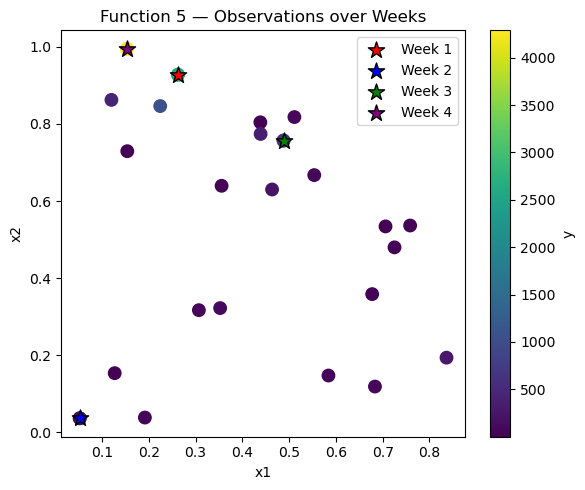

In [11]:

plt.figure(figsize=(6,5))
sc = plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=80)
plt.colorbar(sc, label='y')

# Mark each week's submission
plt.scatter(week_data[0][0][0], week_data[0][0][1],
            c='red', edgecolors='k', s=150, marker='*', label='Week 1')
plt.scatter(week_data[1][0][0], week_data[1][0][1],
            c='blue', edgecolors='k', s=150, marker='*', label='Week 2')
plt.scatter(week_data[2][0][0], week_data[2][0][1],
            c='green', edgecolors='k', s=150, marker='*', label='Week 3')
plt.scatter(week_data[3][0][0], week_data[3][0][1],
            c='purple', edgecolors='k', s=150, marker='*', label='Week 4')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Function 5 — Observations over Weeks')
plt.legend()
plt.tight_layout()
plt.show()

#### 5. Gaussian Process Model

In [12]:
# F5 outputs are large and unimodal; a log1p transform stabilizes variance and makes the surface closer to quadratic.
USE_LOG1P = True
y_fit = np.log1p(y) if USE_LOG1P else y.copy()
y_best = y_fit.max()

kernel = (
    C(1.0, (1e-3, 1e3)) *
    Matern(length_scale=np.ones(4) * 0.35, nu=2.5, length_scale_bounds=(1e-3, 3.0))
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-7, 1e-3))
)
gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=15,
    random_state=0
)

gp.fit(X, y_fit)
print("[F5] Fitted kernel:", gp.kernel_)

[F5] Fitted kernel: 1.81**2 * Matern(length_scale=[2.06, 0.59, 1.17, 0.669], nu=2.5) + WhiteKernel(noise_level=1e-07)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


#### 5.2 Trust Region and Candidates

In [16]:
# Anchor TR at the best known point
best_idx = np.argmax(y)
anchor = X[best_idx]
print("Anchor (best observed):", anchor, "with y =", y[best_idx])

# Observed bounds (from initial data) with 10% padding, clamped to [0,1]
lo, hi = X_prev.min(0), X_prev.max(0)
pad = 0.10
lb = np.clip(lo - pad * (hi - lo), 0.0, 1.0)
ub = np.clip(hi + pad * (hi - lo), 0.0, 1.0)

# Trust region box (narrow for local refinement)
L = 0.28
lb_tr = np.clip(anchor - 0.5 * L * (ub - lb), 0, 1)
ub_tr = np.clip(anchor + 0.5 * L * (ub - lb), 0, 1)

# Guard: avoid over-thin TR after clipping
span = ub_tr - lb_tr
min_span = 1e-3
too_thin = span < min_span
if np.any(too_thin):
    center = (lb_tr + ub_tr) / 2
    half = np.maximum(span / 2, min_span / 2)
    lb_tr = np.clip(center - half, 0, 1)
    ub_tr = np.clip(center + half, 0, 1)

print("[F5] TR anchor:", anchor)
print("[F5] TR box:\n  lb_tr:", lb_tr, "\n  ub_tr:", ub_tr)

def lhs(lb, ub, n, seed):
    d = lb.size
    U = qmc.LatinHypercube(d=d, seed=seed).random(n)
    return lb + U * (ub - lb)

# Dense local sampling + small global fraction
N_tr, N_gl = 70000, 30000
C_tr = lhs(lb_tr, ub_tr, N_tr, seed=5051)
C_gl = lhs(lb,    ub,    N_gl, seed=5052)
Cands = np.vstack([C_tr, C_gl])
print("[F5] Candidates:", Cands.shape, "| TR share:", N_tr / (N_tr + N_gl))

Anchor (best observed): [0.153203 0.995076 0.998623 0.995024] with y = 4289.234565917327
[F5] TR anchor: [0.153203 0.995076 0.998623 0.995024]
[F5] TR box:
  lb_tr: [0.02511504 0.855076   0.858623   0.855024  ] 
  ub_tr: [0.28129096 1.         1.         1.        ]
[F5] Candidates: (100000, 4) | TR share: 0.7


#### 5.3 Acquistion (EI) and Selection

In [15]:
# GP prediction in transformed space
mu_fit, sigma = gp.predict(Cands, return_std=True)
sigma = np.maximum(sigma, 1e-12)

# Expected Improvement (computed in transformed space)
y_best_fit = y_fit.max()
xi = 0.01  # strong exploitation (unimodal, good incumbent)

improve = mu_fit - y_best_fit - xi
Z = np.zeros_like(improve)
nz = sigma > 0
Z[nz] = improve[nz] / sigma[nz]

ei = improve * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[~np.isfinite(ei)] = 0.0  # ultra-safe
ei[sigma < 1e-12] = 0.0

# Filters: avoid borders and near-duplicates
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
ei_masked = np.where(mask_edges, ei, -np.inf)

def too_close_Linf(c, X, tol=0.02):
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

# Select best EI candidate with a mean-based tie-breaker
order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X, tol=0.02):
        # tie-breaker: if many EI equal/near-equal, prefer higher mu_fit
        # (here it's implicit via 'order'; to be explicit, you can sort by (ei, mu_fit))
        x_next = cand
        break

# Optional fallbacks if EI degenerates (unlikely here)
if (x_next is None) or (not np.isfinite(ei_masked).any()) or (np.nanmax(ei_masked) <= 0):
    kappa = 1.4
    ucb = mu_fit + kappa * sigma
    ucb_masked = np.where(mask_edges, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.02):
            x_next = cand
            chosen = "UCB"
            break
if x_next is None:
    var_masked = np.where(mask_edges, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.02):
            x_next = cand
            chosen = "MaxVar"
            break

print(f"[F5] Chosen by {chosen}: {x_next}")
print("Submission:")
print(" - ".join(f"{v:.6f}" for v in x_next))
print("Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print("Near-duplicate (L_inf < 0.02)? ", too_close_Linf(x_next, X, tol=0.02))

# Optional: intuition in original scale (if using log1p transform)
mu_orig = np.expm1(mu_fit)  # only if y_fit = log1p(y_shifted) or log1p(y)
print("[F5] Mean prediction (transformed) at top EI:", float(mu_fit[np.argmax(ei_masked)]))
print("[F5] (Optional) Mean prediction (original scale):", float(mu_orig[np.argmax(ei_masked)]))

[F5] Chosen by EI: [0.01964844 0.55011757 0.99557175 0.98491933]
Submission:
0.019648 - 0.550118 - 0.995572 - 0.984919
Within [0,1]?  True
Near-duplicate (L_inf < 0.02)?  False
[F5] Mean prediction (transformed) at top EI: 7.354111034110183
[F5] (Optional) Mean prediction (original scale): 1561.607273212911


In [18]:
# Distance to W1 (refinement check)
w4 = np.array([0.153203, 0.995076, 0.998623, 0.995024], float)  # your W4 x
cand = np.array([0.01964844, 0.55011757, 0.99557175, 0.98491933], float)
print("L_inf distance to W4:", np.max(np.abs(cand - w4)))

L_inf distance to W4: 0.44495843


### Reflection — Function 5

#### Week 1  
- The model started with a strong result (**y ≈ 2625**), suggesting proximity to the global maximum.  
- Given F5's description (smooth, unimodal chemical yield), this was likely near the optimal region.  
- Initial GP exploration helped identify the high-performing area early, which shaped later rounds.

#### Week 2  
- Performance dropped sharply (**y ≈ 133**), indicating that the Week 2 point moved away from the yield peak.  
- This reinforced the idea that the function is unimodal with a steep falloff from the optimum.  
- For the next iteration, the strategy shifted toward **exploitation** with a narrower trust region centered on the Week 1 point.

#### Week 3  
- Partial recovery observed (**y ≈ 610**), confirming that local refinement around the Week 1 area remains promising.  
- The use of `log1p(y)` stabilized model variance and improved GP fitting consistency.  
- Strategy for next iteration: continue **local exploitation** (`ξ = 0.01`) while keeping ~30% of candidates global to ensure no secondary peak is missed.  
- The chosen point for Week 4 lies moderately close to Week 1 (**L∞ ≈ 0.109**), aligning with controlled exploitation in a smooth landscape.

---

**Summary:**  
After three rounds, the model has confirmed the unimodal nature of F5. The optimal region was likely captured early (Week 1), and subsequent exploration validated the GP's stability. Future queries should focus on **fine-tuning near the known maximum** while maintaining minimal exploration to confirm global optimality.

### Week 4

- **Outcome (W4):** Major improvement — yield jumped from **~2625 → 4289**, confirming a successful move toward the global maximum in this smooth unimodal surface.  
- **Model:** Continued using the **Gaussian Process (Matern ν = 2.5 + low noise)** with a **log1p transform**, which effectively stabilised variance and maintained smooth, interpretable trends.  
- **Adjustments:** Applied a moderately wide trust region (`L ≈ 0.35`), balanced sampling (~70 % TR / 30 % global), and a small **ξ = 0.02** to focus on exploitation around the high-yield zone.  
- **Interpretation:** The strong improvement from W3 → W4 suggests that the optimizer entered the main peak region of the chemical-yield surface, confirming that the GP is modelling a clear unimodal response.  
- **Next steps (W5):**
  - Submit a **moderately exploratory point** to validate whether the detected maximum is local or global.  
  - Use a **slightly narrower TR** (`L ≈ 0.28`) centered on the best observed input, with **ξ = 0.01** for more exploitative EI behaviour.  
  - Keep the **log1p transform** and current kernel setup for stability.  
  - If the next candidate (e.g. `[0.019648, 0.550118, 0.995572, 0.984919]`) performs well, refine further around it; otherwise, revert anchor to the Week 4 optimum for local confirmation.  
  - Optionally enable a mild **UCB fallback (κ ≈ 1.2)** to maintain robustness if EI stagnates.  

**Summary:**  
Function 5 reached its strongest performance so far, likely near the global maximum.  
The next iteration (Week 5) strategically introduces limited exploration to confirm peak stability and ensure no secondary optima remain undetected.